# Integrating ODE in Julia

In this notebook we perform time-integration of various of (systems of) ordinary differential equations. 

In [3]:
using LinearAlgebra
using DifferentialEquations
using ModelingToolkit
using Plots 

Documentation of DifferentialEquations.jl  
<ul>
<li> <a href="https://diffeq.sciml.ai/dev/tutorials/ode_example/"> Examples </a>   
<li> <a href="https://diffeq.sciml.ai/stable/"> Documentation of DifferentialEquations.jl on Github </a>  
<li> <a href="https://diffeq.sciml.ai/dev/features/performance_overloads/#Function-Type-Definitions"> Specifying Jacobian types using DifferentialEquations.jl </a>   
</ul>   
Documentation of ModelingToolkit.jl (for ODE with parameters)
<ul>
<li> <a href="https://mtk.sciml.ai/stable/"> Documentation of ModelingToolkit.jl on Github </a>    
</ul> 
</ul>
Documentation of Catalist.jl (for chemical reaction mechanisms)
<ul>
<li> <a href="https://catalyst.sciml.ai/stable/"> Documentation of Catalist.jl on Github </a>    
</ul> 
Documentation of ReactionMechanismSimulator.jl (again for chemical reaction mechanisms)
<ul>
<li> <a href="https://catalyst.sciml.ai/stable/"> Documentation of Catalist.jl on Github </a>    
</ul>
Documentation on GRI-30 mechanism (as example of a chemical reaction mechanism)
<ul>
<li> <a href="https://cantera.org/tutorials/python-tutorial.html"> GRI30.xml </a>  
<li> <a href="https://discourse.julialang.org/t/calling-chemical-kinetics-solvers-like-chemkin-or-cantera-from-julia/50568/2"> Reading mechanism into Julia</a> (using Python interface to Cantera) 
</ul>

## Part 1/: Single ODE Example: Linear Right-Hand Side Function 

This example is taken from [https://diffeq.sciml.ai/stable/solvers/dynamical_solve/]. For this example, a reference solution can be constructed using seperation of variables (or using sympy). We also plot the time-step evoluation.

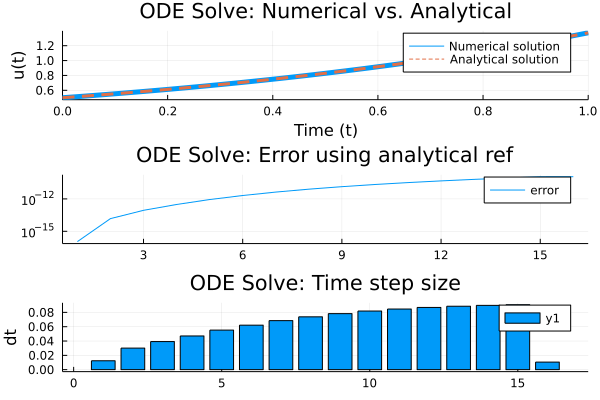

In [4]:
# problem set-up: set driving function 
f(u,p,t) = 1.01*u
# problem set-up: set initial guess 
u0=1/2
# problem set-up: set the time span 
tspan = (0.0,1.0)
# set ODE function (not strictly necessary at this stage)
ff = ODEFunction(f)
# problem set-up: define the ODE problem 
prob = ODEProblem(ff,u0,tspan)

# perform time integration 
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)
#sol = solve(prob,Tsit5())
# compute the time step 
dt = collect(sol.t[i+1]-sol.t[i] for i in 1:length(sol.t)-1)
sampled = collect(0.5*exp(1.01t) for t in sol.t)
merror = abs.(sol.u - sampled)

# plot numerical and analytical solution 
p1=plot(sol,linewidth=5,title="ODE Solve: Numerical vs. Analytical",
     xaxis="Time (t)",yaxis="u(t)",label="Numerical solution") # legend=false
p1=plot!(sol.t, t->0.5*exp(1.01t),lw=3,ls=:dash,label="Analytical solution");
p2=plot(merror[2:end], yaxis=:log, label="error", title="ODE Solve: Error using analytical ref")
p3=bar(dt,yaxis="dt", title="ODE Solve: Time step size"); 
plot(p1,p2,p3,layout=(3,1))

## Part 2/: Single ODE Example: Non-Linear Right-Hand Side

In this example, the analytical reference solution can still be found using seperation of variables (or using sympy). 

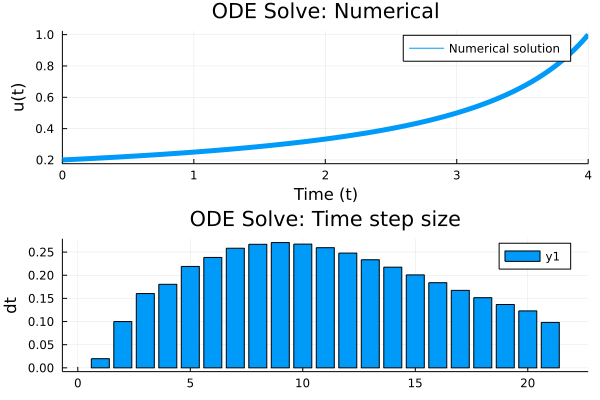

In [5]:
# problem set-up: set driving function 
f(u,p,t) = u*u
# problem set-up: set initial guess 
u0=1/5
# problem set-up: set the time span 
tspan = (0.0,4.0)
# set ODE function (not strictly necessary at this stage)
ff = ODEFunction(f)
# problem set-up: define the ODE problem 
prob = ODEProblem(ff,u0,tspan)

# perform time integration 
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)
#sol = solve(prob,Tsit5())
# compute the time step 
dt = collect(sol.t[i+1]-sol.t[i] for i in 1:length(sol.t)-1)
sampled = collect(0.5*exp(1.01t) for t in sol.t)
merror = abs.(sol.u - sampled)

# plot numerical and analytical solution 
p1=plot(sol,linewidth=5,title="ODE Solve: Numerical",
     xaxis="Time (t)",yaxis="u(t)",label="Numerical solution") # legend=false
p2=bar(dt,yaxis="dt", title="ODE Solve: Time step size"); 
plot(p1,p2,layout=(2,1))

## Part 3/: Same example as before using in-place function for right-hand side function

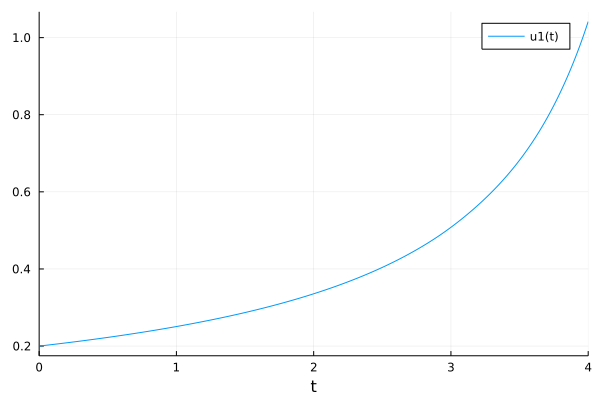

In [6]:
function f!(du,u,p,t)
# observe that specifying first component of u is required here
    du[1] = 1.01*u[1]*u[1]
end 

# observe that specifying u0 as a vector is required here 
u0 = [.2];
tspan = [0.,4.]
prob = ODEProblem(f!,u0,tspan)

sol = solve(prob)

plot(sol,vars=(1))

## Part 4/: Same example as before using Jacobian function

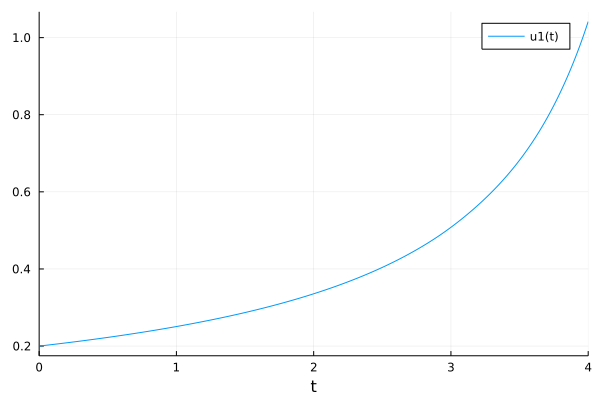

In [7]:
function f!(du,u,p,t)
# observe that specifying first component of u is required here
    du[1] = 1.01*u[1]*u[1]
end 

function j!(J,u,p,t)
# observe that specifying first component of u is required here
    J[1,1] = 2.02*u[1]
end 

# observe that specifying u0 as a vector is required here 
u0 = [.2];
tspan = [0.,4.]
prob = ODEProblem(f!,u0,tspan)

sol = solve(prob, jac=j!)

plot(sol,vars=(1))

 ## Part 5/: Coupled System Example: Lorenz

This example is taken from [https://diffeq.sciml.ai/stable/solvers/dynamical_solve/]. 

In [8]:
function lorenz!(du,u,p,t)
 du[1] = 10.0*(u[2]-u[1])
 du[2] = u[1]*(28.0-u[3]) - u[2]
 du[3] = u[1]*u[2] - (8/3)*u[3]
end

lorenz! (generic function with 1 method)

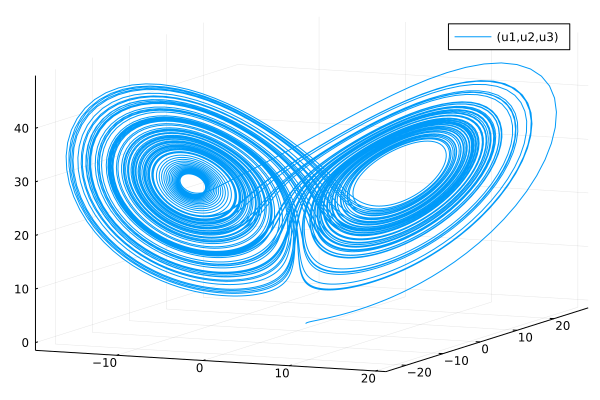

In [9]:
u0 = [1.0;0.0;0.0]
tspan = (0.0,100.0)
prob = ODEProblem(lorenz!,u0,tspan)
sol = solve(prob)
plot(sol,vars=(1,2,3))

## Part 6/: Coupled System Example: SIR 

Adapted from previous example to be able to arrive at chemical reactions in a next step.

In [10]:
function sir!(du,u,p,t)
 beta = 0.69 
 gamma = 0.3
 du[1] = -beta*u[2]*u[1]
 du[2] = beta*u[2]*u[1] - gamma*u[2]
 du[3] = gamma*u[2]
end

sir! (generic function with 1 method)

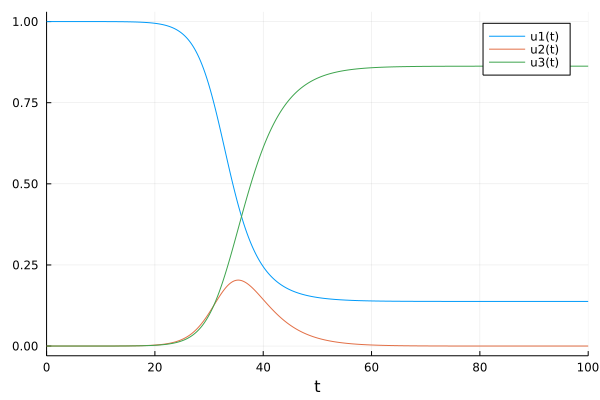

In [11]:
u0 = [1.0;1.27e-6;0.0]
tspan = (0.0,100.0)
prob = ODEProblem(sir!,u0,tspan)
sol = solve(prob)
plot(sol,vars=1)
plot!(sol,vars=2)
plot!(sol,vars=3)

## Part 7/: Coupled System Example: Single Step Mechanism 

In [12]:
function methane!(du,u,p,t)
# print("Hello!\n")
 k = 0.5 
 du[1] = -k*u[1]*u[2]*u[2]
 du[2] = -k*u[1]*u[2]*u[2]
 du[3] = k*u[1]*u[2]*u[2]
 du[4] = k*u[1]*u[2]*u[2]
end

methane! (generic function with 1 method)

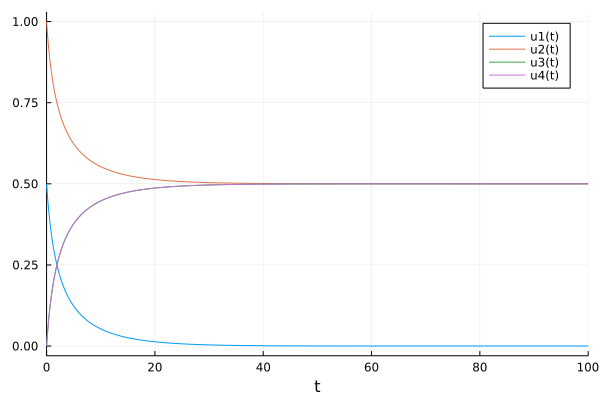

In [13]:
u0 = [0.5;1.0;0.0;0.0]
tspan = (0.0,100.0)
prob = ODEProblem(methane!,u0,tspan)
sol = solve(prob)
plot(sol,vars=1)
plot!(sol,vars=2)
plot!(sol,vars=3)
plot!(sol,vars=4)